In [1]:
import pandas as pd
from torch.utils.data import Dataset, Sampler, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import numpy as np
import sys
import os
import torch
from PIL import Image

transform = Compose(
    [
    Resize((112, 112)),
    ToTensor(), 
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [2]:
class TripletDataset(Dataset):
    def __init__(self, images_df, transform=None, dtype=torch.bfloat16):
        self.labels = images_df['id'].values
        self.image_paths = images_df['path'].values
        self.transform = transform
        self.dtype = dtype

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        image = image.to(self.dtype)
        label = torch.tensor(self.labels[idx], dtype=torch.int16)
        
        return image, label, idx

class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, accumulation, batch_size):
        self.dataset = dataset
        self.accumulation = accumulation
        self.batch_size = batch_size
        self.accumulation_steps = accumulation // batch_size
        self.label_set = list(set(dataset.labels))
        self.labels_to_indices = {label: np.where(np.array(dataset.labels) == label)[0] for label in self.label_set}
        self.num_batches = len(dataset) // batch_size
        self.num_accumulation_batches = self.num_batches // self.accumulation_steps

    def __iter__(self):
        for _ in range(self.num_accumulation_batches):
            selected_labels = np.random.choice(self.label_set, self.batch_size, replace=False)
            indices = []
            for _ in range(self.accumulation_steps):
                batch_indices = []
                for label in selected_labels:
                    idx = np.random.choice(self.labels_to_indices[label])
                    batch_indices.append(idx)
                indices.extend(batch_indices)
                yield batch_indices

    def __len__(self):
        return self.num_accumulation_batches

In [3]:
df = pd.read_csv('../data/CASIA/casia_train.csv')

batch_size = n_classes = 32
accumulation = 512

df['path'] = df['path'].apply(lambda x: '../data/CASIA/casia-faces/' + x)
dataset = TripletDataset(df, transform=transform)
sampler = BalancedBatchSampler(dataset=dataset, batch_size=batch_size, accumulation=accumulation)
dataloader = DataLoader(dataset, batch_sampler=sampler, pin_memory=True, num_workers=1)
print(len(dataloader)  * accumulation)

76800


In [4]:
# import numpy as np

# accumulation = 512
# batch_size = n_classes = 32 # isso é o mesmo que n_classes
# accumulation_steps = accumulation // batch_size

# # Seed
# np.random.seed(42)

# label_set = set(dataset.labels)
# labels_to_indices = {label: np.where(np.array(dataset.labels) == label)[0] for label in label_set}

# # Selecionar n_classes labels aleatórias
# selected_labels = np.random.choice(list(label_set), batch_size, replace=False)

# # Selecionar accumulation_steps imagens para cada label, retornar um dict com os indices
# indices = {label: np.random.choice(labels_to_indices[label], accumulation_steps, replace=False) for label in selected_labels}

# # Organizar em um array com outros batch_size arrays, de forma que cada array tenha accumulation_steps elementos, sendo 1 de cada label
# indices_array = np.array([[indices[label][i] for label in selected_labels] for i in range(accumulation_steps)])
# len(indices_array)

In [4]:
from tqdm.notebook import tqdm

# Itera pelo dataloader, salvando a quantidade de cada classe em um dicionário
classes = {}
indices = []

# Contar quantos de cada classe num batch
# Adicionar tqdm
for i, batch in enumerate(tqdm(dataloader, total=(len(dataloader) * accumulation))):
    _, labels, idx = batch
    indices.append(idx)
    
    for label in labels:
        if label in classes:
            classes[label] += 1
        else:
            classes[label] = 1
            
    # Parar quando acumular
    if (i+1) % (accumulation // batch_size) == 0: break

  0%|          | 0/76800 [00:00<?, ?it/s]

In [20]:
indices = np.array(indices).flatten()
len(indices)#, indices

(32,
 array([11595, 28392, 65517, 29194, 75798, 51108, 50397, 42001, 11569,
        28328, 65516, 29266, 75842, 51183, 50324, 42064, 11593, 28311,
        65428, 29300, 75896, 51075, 50373, 42009, 11539, 28375, 65461,
        29230, 75815, 51118, 50392, 41988]))

In [21]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def denormalize(tensor, mean, std):
    if tensor.ndim == 3:  # Check if the tensor is (C, H, W)
        mean = torch.tensor(mean).view(-1, 1, 1)
        std = torch.tensor(std).view(-1, 1, 1)
        tensor = tensor * std + mean  # Apply denormalization
    elif tensor.ndim == 4:  # Check if the tensor is (B, C, H, W)
        mean = torch.tensor(mean).view(1, -1, 1, 1)
        std = torch.tensor(std).view(1, -1, 1, 1)
        tensor = tensor * std + mean  # Apply denormalization for batch of images
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def plot_images_side_by_side(dataset, indices, images_per_row=10, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    num_images = len(indices)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    
    plt.figure(figsize=(images_per_row * 2, num_rows * 2))
    
    for idx, image_index in enumerate(indices, start=1):
        image, label, index = dataset[image_index]  # Assuming dataset returns a tuple (image, label)
        image = denormalize(image, mean, std)  # Denormalize the image
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C)
            image = image.numpy()  # Convert to numpy array
        
        plt.subplot(num_rows, images_per_row, idx)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Index: {image_index}\nLabel: {label}', fontsize=10)  # Display index and label
    
    plt.tight_layout()
    plt.show()

In [22]:
len(indices)

32

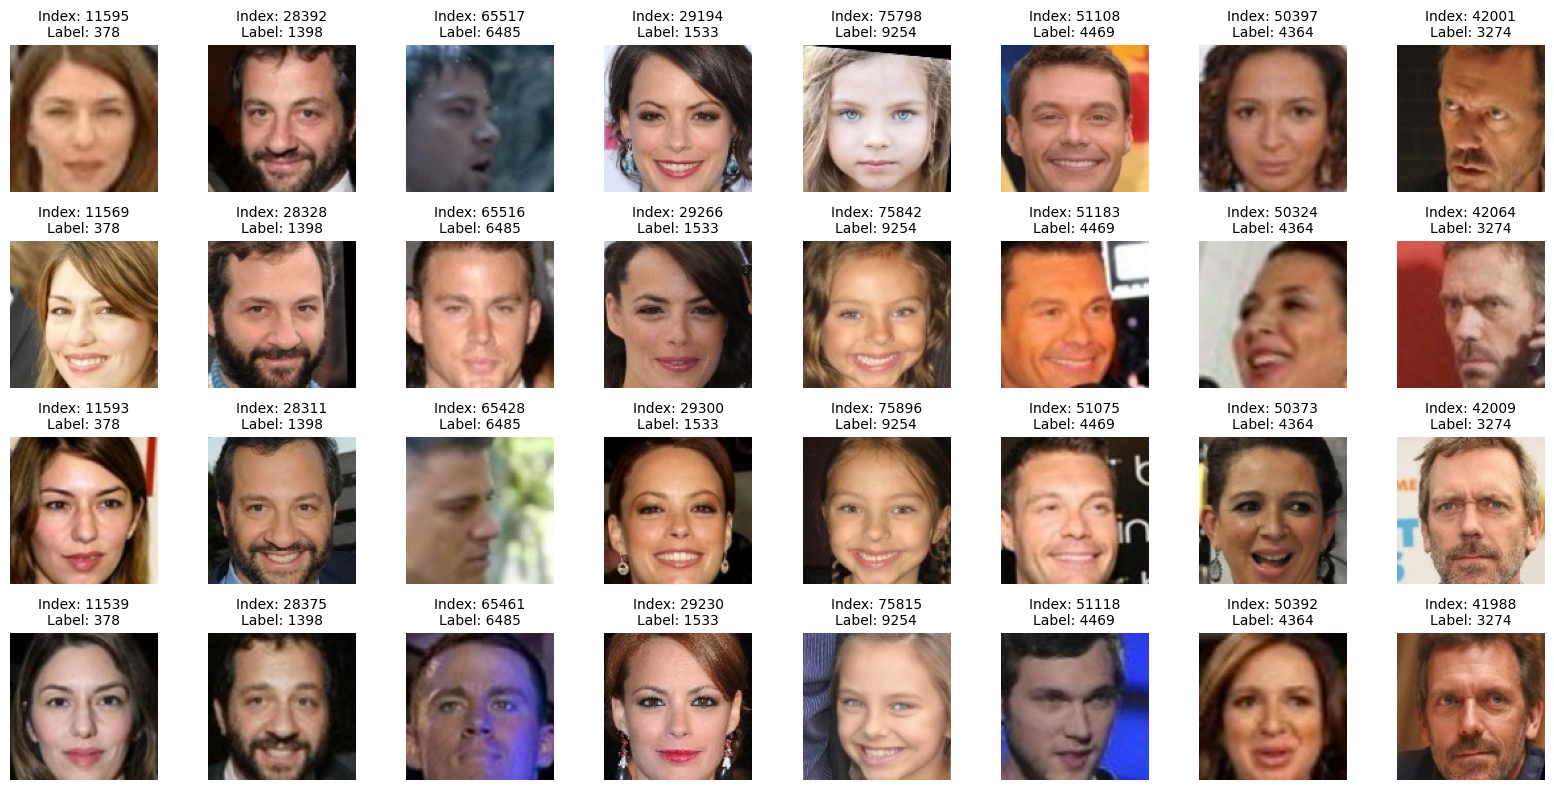

In [23]:
plot_images_side_by_side(dataset, indices, images_per_row=8)

In [10]:
# Converter o dicionário para um dataframe
res_df = pd.DataFrame.from_dict(classes, orient='index', columns=['count'])

In [11]:
# Adicionar uma linha 'Total' com a soma
df_res = pd.concat([res_df.sort_index(), pd.DataFrame(res_df.sum(), columns=['Total']).T]).T

In [12]:
df_res.shape[1]-1

60

In [13]:
df_res

,12,25,56,245,254,392,496,673,852,869,...,7518,7714,7803,7913,7942,8712,9199,9258,9833,Total
count,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,256


In [14]:
df_res.T

,count
12,4
25,4
56,4
245,4
254,4
...,...
8712,4
9199,4
9258,4
9833,4
